# CIFAR-100 Fixup Patch
source: https://github.com/hongyi-zhang/Fixup

In [ ]:
! pip uninstall torch torchvision -y
! pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.4.0:
  Successfully uninstalled torch-1.4.0
Uninstalling torchvision-0.5.0:
  Successfully uninstalled torchvision-0.5.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
import matplotlib
import pickle
import time
import datetime
import numpy
import platform

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(numpy.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
import numpy as np
import random

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))
print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

python version:      3.6.9
torch version:       1.4.0
torchvision version: 0.5.0
numpy version:       1.18.5
matplotlib version:  3.2.2
pickle version:      4.0
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4


Set CUDNN to deterministic for reproducibility reasons:

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mount GDrive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
base_url = '/content/gdrive/My Drive/neuralnet-patchinit/'

## Data

### Specify Dataset

Define data transform functions:

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Define training and test set:

In [ ]:
# training set
trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)

# test set
testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


### Load Data

In [ ]:
batch_size = 128

In [ ]:
if use_cuda:
    n_gpu = torch.cuda.device_count()
    batch_size *= n_gpu

    print('n_gpu: {}'.format(n_gpu))
    print('batch_size: {}'.format(batch_size))

n_gpu: 1
batch_size: 128


Create train and test data loader:

In [ ]:
# create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

# create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

## Define Training and Test Methods

In [ ]:
def train(epoch):
    net.train()

    train_loss = 0
    correct = 0
    total = 0

    print('\n=> Training Epoch #%d' % (epoch))

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # generate mixed inputs, two one-hot label vectors and mixing coefficient
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha, use_cuda)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss_func = mixup_criterion(targets_a, targets_b, lam)
        loss = loss_func(criterion, outputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).float()).cpu().sum() + ((1 - lam) * predicted.eq(targets_b.data).float()).cpu().sum()
        acc = 100.*float(correct)/float(total)

        if batch_idx % 20 == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%% [%3d/%3d]' % (
                epoch, n_epoch, batch_idx+1, (len(trainset)//batch_size)+1, loss.item(), acc, correct, total
            ))


def test(epoch):
    net.eval()

    test_loss = 0
    correct = 0
    total = 0

    all_targs = []
    all_preds = []

    print('\n=> Testing Epoch #%d' % (epoch))

    with torch.no_grad():
        # Run testing
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = net(inputs)
            loss = cel(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            all_preds.append(predicted.cpu().numpy())
            all_targs.append(targets.cpu().numpy())

        # Print Results
        acc = 100.*float(correct)/float(total)
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))

    all_preds = np.hstack(np.array(all_preds))
    all_targs = np.hstack(np.array(all_targs))

    return (acc, all_preds, all_targs)


def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = base_learning_rate
    if epoch <= 9 and lr > 0.1:
        # warm-up training for large minibatch
        lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        if param_group['initial_lr'] == base_learning_rate:
            param_group['lr'] = lr
        else:
            if epoch <= 9:
                param_group['lr'] = param_group['initial_lr'] * lr / base_learning_rate
            elif epoch < 100:
                param_group['lr'] = param_group['initial_lr']
            elif epoch < 150:
                param_group['lr'] = param_group['initial_lr'] / 10.
            else:
                param_group['lr'] = param_group['initial_lr'] / 100.
    return lr

## FixUp Architecture

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True, per_sample=False):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    if alpha > 0. and not per_sample:
        lam = torch.zeros(y.size()).fill_(np.random.beta(alpha, alpha)).cuda()
        mixed_x = lam.view(-1, 1, 1, 1) * x + (1 - lam.view(-1, 1, 1, 1)) * x[index,:]
    elif alpha > 0.:
        lam = torch.Tensor(np.random.beta(alpha, alpha, size=y.size())).cuda()
        mixed_x = lam.view(-1, 1, 1, 1) * x + (1 - lam.view(-1, 1, 1, 1)) * x[index,:]
    else:
        lam = torch.ones(y.size()).cuda()
        mixed_x = x

    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_lam_idx(batch_size, alpha, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    return lam, index    


def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: criterion(pred, y_a, lam) + criterion(pred, y_b, 1 - lam)


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class FixupBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(FixupBasicBlock, self).__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.bias1a = nn.Parameter(torch.zeros(1))
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bias1b = nn.Parameter(torch.zeros(1))
        self.relu = nn.ReLU(inplace=True)
        self.bias2a = nn.Parameter(torch.zeros(1))
        self.conv2 = conv3x3(planes, planes)
        self.scale = nn.Parameter(torch.ones(1))
        self.bias2b = nn.Parameter(torch.zeros(1))
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x + self.bias1a)
        out = self.relu(out + self.bias1b)

        out = self.conv2(out + self.bias2a)
        out = out * self.scale + self.bias2b

        if self.downsample is not None:
            identity = self.downsample(x + self.bias1a)
            identity = torch.cat((identity, torch.zeros_like(identity)), 1)

        out += identity
        out = self.relu(out)

        return out


class FixupResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        super(FixupResNet, self).__init__()
        self.num_layers = sum(layers)
        self.inplanes = 16
        self.conv1 = conv3x3(3, 16)
        self.bias1 = nn.Parameter(torch.zeros(1))
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.bias2 = nn.Parameter(torch.zeros(1))
        self.fc = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, FixupBasicBlock):
                nn.init.normal_(m.conv1.weight, mean=0, std=np.sqrt(2 / (m.conv1.weight.shape[0] * np.prod(m.conv1.weight.shape[2:]))) * self.num_layers ** (-0.5))
                nn.init.constant_(m.conv2.weight, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 0)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.AvgPool2d(1, stride=stride)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x + self.bias1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x + self.bias2)

        return x


def fixup_resnet20(**kwargs):
    """Constructs a Fixup-ResNet-20 model.
    """
    model = FixupResNet(FixupBasicBlock, [3, 3, 3], **kwargs)
    return model

## Create Patch-based Weight Init

In [ ]:
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

patch_layer1_path = '/content/gdrive/My Drive/neuralnet-patchinit/results/cifar100-fixup-tests/patches/patches-cifar100-fixup-layer1-pca-kmeans.txt'
patch_layer2_path = '/content/gdrive/My Drive/neuralnet-patchinit/results/cifar100-fixup-tests/patches/patches-cifar100-fixup-layer2-pca-kmeans.txt'
patch_layer3_path = '/content/gdrive/My Drive/neuralnet-patchinit/results/cifar100-fixup-tests/patches/patches-cifar100-fixup-layer3-pca-kmeans.txt'

### Load Patches

In [ ]:
def show_patches(patches):
    print("tensor shape: " + str(patches.shape))
    
    fig = plt.figure(figsize=(8,8))
    for i in range(patches.shape[0]):
        plt.subplot(4,4,i+1)
        plt.tight_layout()
        patch = np.moveaxis(patches[i], 0, -1)
        plt.imshow(patch, cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])

#### Patches Layer 1

In [ ]:
with open(patch_layer1_path, "rb") as fp:
    patches_layer1 = pickle.load(fp)

patches_layer1 = patches_layer1.astype(np.float32)
patches_layer1.shape, patches_layer1.dtype

((16, 3, 15, 15), dtype('float32'))

tensor shape: (16, 3, 15, 15)


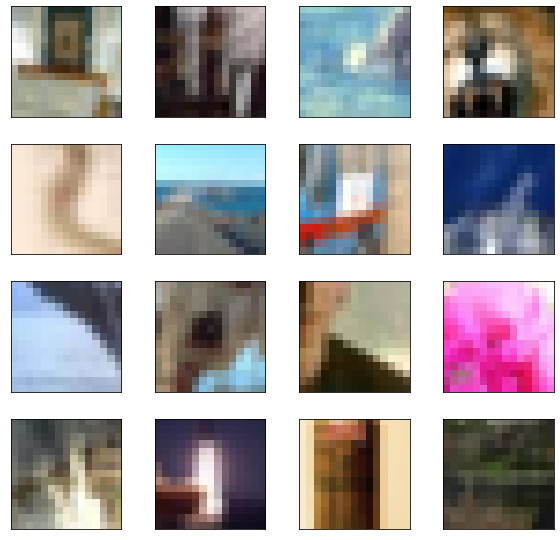

In [ ]:
show_patches(patches_layer1)

#### Patches Layer 2

In [ ]:
with open(patch_layer2_path, "rb") as fp:
    patches_layer2 = pickle.load(fp)

patches_layer2 = patches_layer2.astype(np.float32)
patches_layer2.shape, patches_layer2.dtype

((86, 3, 15, 15), dtype('float32'))

tensor shape: (16, 3, 15, 15)


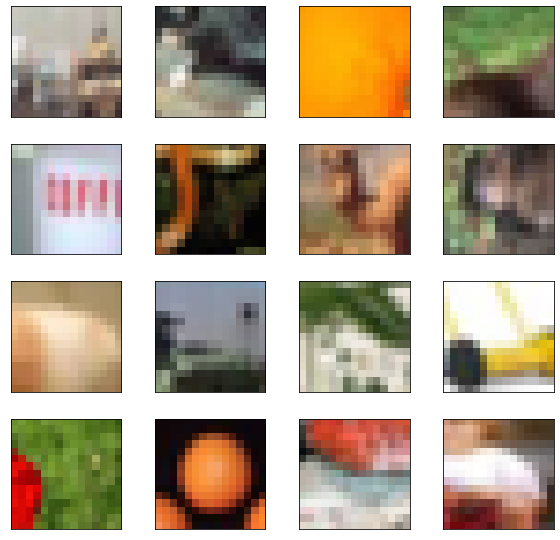

In [ ]:
show_patches(patches_layer2[:16])

In [ ]:
patches_layer2_a = patches_layer2[:85]
patches_layer2_a = patches_layer2_a.reshape(255,1,15,15)
patches_layer2_b = patches_layer2[85]
patches_layer2_b_m = np.expand_dims(np.expand_dims(np.mean(patches_layer2_b, axis=0),0),0)
patches_layer2_c = np.vstack((patches_layer2_a,patches_layer2_b_m))
patches_layer2 = patches_layer2_c.reshape(16,16,15,15)

patches_layer2.shape

(16, 16, 15, 15)

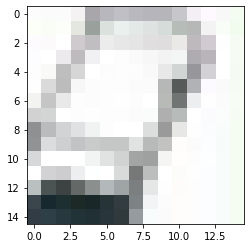

In [ ]:
plt.imshow(np.moveaxis(patches_layer2[3,:3], 0, -1), cmap='gray', interpolation='none')

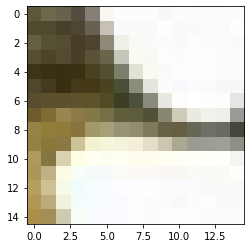

In [ ]:
plt.imshow(np.moveaxis(patches_layer2[6,:3], 0, -1), cmap='gray', interpolation='none')

#### Patches Layer 3

In [ ]:
with open(patch_layer3_path, "rb") as fp:
    patches_layer3 = pickle.load(fp)

patches_layer3 = patches_layer3.astype(np.float32)
patches_layer3.shape, patches_layer3.dtype

((342, 3, 15, 15), dtype('float32'))

tensor shape: (16, 3, 15, 15)


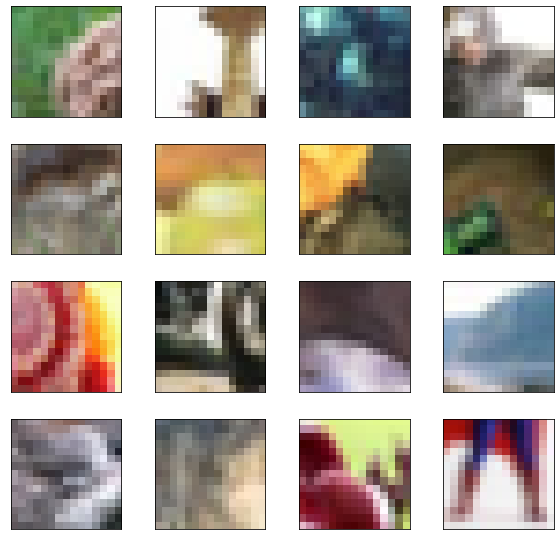

In [ ]:
show_patches(patches_layer3[:16])

In [ ]:
patches_layer3_a = patches_layer3[:341]
patches_layer3_a = patches_layer3_a.reshape(1023,1,15,15)
patches_layer3_b = patches_layer3[341]
patches_layer3_b_m = np.expand_dims(np.expand_dims(np.mean(patches_layer3_b, axis=0),0),0)
patches_layer3_c = np.vstack((patches_layer3_a,patches_layer3_b_m))
patches_layer3 = patches_layer3_c.reshape(32,32,15,15)

patches_layer3.shape

(32, 32, 15, 15)

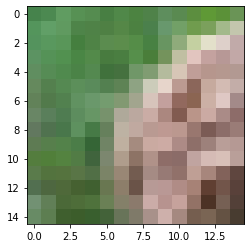

In [ ]:
plt.imshow(np.moveaxis(patches_layer3[0,:3], 0, -1), cmap='gray', interpolation='none')

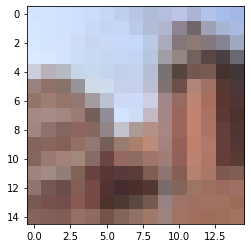

In [ ]:
plt.imshow(np.moveaxis(patches_layer3[21,:3], 0, -1), cmap='gray', interpolation='none')

### Normalize Patches

In [ ]:
def normalize(patches):
    a = np.mean(patches, axis=(1,2))
    
    for i in range(patches.shape[0]):
        p = patches[i]
        p -= a[i]
        patches[i] = p
        
    return patches

In [ ]:
patches_layer1 = normalize(patches_layer1)
patches_layer2 = normalize(patches_layer2)
patches_layer3 = normalize(patches_layer3)

### Downsample Patches

#### Downsample Layer 1 Patches

In [ ]:
patches_layer1 = torch.from_numpy(patches_layer1)
patches_layer1 = F.interpolate(patches_layer1, size=3)

print("tensor shape: " + str(patches_layer1.shape))

tensor shape: torch.Size([16, 3, 3, 3])


#### Downsample Layer 2 Patches

In [ ]:
patches_layer2 = torch.from_numpy(patches_layer2)
patches_layer2 = F.interpolate(patches_layer2, size=3)

print("tensor shape: " + str(patches_layer2.shape))

tensor shape: torch.Size([16, 16, 3, 3])


#### Downsample Layer 3 Patches

In [ ]:
patches_layer3 = torch.from_numpy(patches_layer3)
patches_layer3 = F.interpolate(patches_layer3, size=3)

print("tensor shape: " + str(patches_layer3.shape))

tensor shape: torch.Size([32, 32, 3, 3])


## Create Random Seed Values

Create 5 random numbers (between 0 and 99) for seed values:

In [ ]:
#random_seed_list = np.random.choice(np.arange(100), 5)
#random_seed_list

In [ ]:
#with open(base_url + "random-seeds.txt", "wb") as fp:
#  pickle.dump(random_seed_list, fp)

In [ ]:
with open(base_url + "seeds/random-seeds.txt", "rb") as fp:
  random_seed_list = pickle.load(fp)

random_seed_list = [random_seed_list[0]]; random_seed_list

[76]

## Training

In [ ]:
n_epoch = 200

alpha = 1.

base_lr = 0.1
base_learning_rate = base_lr * batch_size / 128.
mom = 0.9
decay = 1e-4

use_sgdr = True

result_accs_base_path = base_url + 'results/accs-cifar100-fixup-patch'
result_preds_base_path = base_url + 'results/preds-cifar100-fixup-patch'
result_targs_base_path = base_url + 'results/targs-cifar100-fixup-patch'

In [ ]:
def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

In [ ]:
if use_cuda:
    n_gpu = torch.cuda.device_count()
    base_learning_rate *= n_gpu

    print('n_gpu: {}'.format(n_gpu))
    print('base_learning_rate: {}'.format(base_learning_rate))

n_gpu: 1
base_learning_rate: 0.1


In [ ]:
net = fixup_resnet20(); net

FixupResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): FixupBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): FixupBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): FixupBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): FixupBasicBlock(
      (conv1): Conv2d(16, 32, kernel_si

Create model and start training for each of the 5 seeds:

In [ ]:
accs_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    print()
    
    # Set Seed Value
    torch.manual_seed(s)
    torch.cuda.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    
    # Create Model
    print('[Phase 1] : Model setup')
    net = fixup_resnet20()

    if use_cuda:
        net.cuda()
        print('Using', torch.cuda.device_count(), 'GPUs.')
      
    print()

    cel = nn.CrossEntropyLoss()
    criterion = lambda pred, target, lam: (-F.log_softmax(pred, dim=1) * torch.zeros(pred.size()).cuda().scatter_(1, target.data.view(-1, 1), lam.view(-1, 1))).sum(dim=1).mean()
    parameters_bias = [p[1] for p in net.named_parameters() if 'bias' in p[0]]
    parameters_scale = [p[1] for p in net.named_parameters() if 'scale' in p[0]]
    parameters_others = [p[1] for p in net.named_parameters() if not ('bias' in p[0] or 'scale' in p[0])]
    optimizer = optim.SGD(
        [{'params': parameters_bias, 'lr': base_lr/10.}, 
        {'params': parameters_scale, 'lr': base_lr/10.}, 
        {'params': parameters_others}], 
        lr=base_learning_rate, 
        momentum=mom, 
        weight_decay=decay
    )

    sgdr = CosineAnnealingLR(optimizer, n_epoch, eta_min=0, last_epoch=-1)

    # Set Patches as Weight Tensor
    print()
    print('----- Layer Weight Statistics --- Begin')
    print()
    print('layer1 - requires grad = {}'.format(net.conv1.weight.requires_grad))
    print('layer1 weights shape: ' + str(net.conv1.weight.shape))
    print('min value:            ' + str(torch.min(net.conv1.weight).item()))
    print('max value:            ' + str(torch.max(net.conv1.weight).item()))
    print()
    print('layer2 - requires grad = {}'.format(net.layer1[2].conv2.weight.requires_grad))
    print('layer2 weights shape: ' + str(net.layer1[2].conv2.weight.shape))
    print('min value:            ' + str(torch.min(net.layer1[2].conv2.weight).item()))
    print('max value:            ' + str(torch.max(net.layer1[2].conv2.weight).item()))
    print()
    #print('layer3 - requires grad = {}'.format(net.layer2[2].conv2.weight.requires_grad))
    #print('layer3 weights shape: ' + str(net.layer2[2].conv2.weight.shape))
    #print('min value:            ' + str(torch.min(net.layer2[2].conv2.weight).item()))
    #print('max value:            ' + str(torch.max(net.layer2[2].conv2.weight).item()))
    #print()


    print('[Phase 2] : Init Weights with Patches')
    print()

    patches_layer1.requires_grad = True
    patches_layer2.requires_grad = True
    #patches_layer3.requires_grad = True

    with torch.no_grad():
        net.conv1.weight = nn.Parameter(patches_layer1.clone().cuda())
        net.layer1[2].conv2.weight = nn.Parameter(patches_layer2.clone().cuda())
        #net.layer2[2].conv2.weight = nn.Parameter(patches_layer3.clone().cuda())

    print('layer1 - requires grad = {}'.format(net.conv1.weight.requires_grad))
    print('layer1 weights shape: ' + str(net.conv1.weight.shape))
    print('min value:            ' + str(torch.min(net.conv1.weight).item()))
    print('max value:            ' + str(torch.max(net.conv1.weight).item()))
    print()
    print('layer2 - requires grad = {}'.format(net.layer1[2].conv2.weight.requires_grad))
    print('layer2 weights shape: ' + str(net.layer1[2].conv2.weight.shape))
    print('min value:            ' + str(torch.min(net.layer1[2].conv2.weight).item()))
    print('max value:            ' + str(torch.max(net.layer1[2].conv2.weight).item()))
    print()
    #print('layer3 - requires grad = {}'.format(net.layer2[2].conv2.weight.requires_grad))
    #print('layer3 weights shape: ' + str(net.layer2[2].conv2.weight.shape))
    #print('min value:            ' + str(torch.min(net.layer2[2].conv2.weight).item()))
    #print('max value:            ' + str(torch.max(net.layer2[2].conv2.weight).item()))
    #print()
    print('----- Layer Weight Statistics --- End')
    print()
    
    # Start Training
    print('[Phase 2] : Training model')
    print('| Training Epochs = ' + str(n_epoch))
    print()

    test_accs = []
    test_targs = []
    test_preds = []

    start_epoch = 1
    elapsed_time = 0

    for epoch in range(start_epoch, start_epoch+n_epoch):
        start_time = time.time()

        # Train
        train(epoch)
        print()

        lr = 0.
        if use_sgdr:
            sgdr.step()
            for param_group in optimizer.param_groups:
                lr = param_group['lr']
                break
        else:
            lr = adjust_learning_rate(optimizer, epoch)
    
        # Test
        test_acc, all_preds, all_targs  = test(epoch)
        test_accs.append(test_acc)
        test_preds.append(all_preds)
        test_targs.append(all_targs)
        print()

        # Measure time
        epoch_time = time.time() - start_time
        elapsed_time += epoch_time
        print('----- Elapsed time : %d:%02d:%02d'  % (get_hms(elapsed_time)))
        print()
    
    # Save Result
    test_preds = np.vstack(np.array(test_preds))
    test_targs = np.vstack(np.array(test_targs))

    print('[Phase 3] : Save results')
    print('| accs:  {}'.format(len(test_accs)))
    print('| targs: {}'.format(test_preds.shape))
    print('| preds: {}'.format(test_targs.shape))

    result_accs_path = result_accs_base_path + '-seed{}.txt'.format(s)
    result_preds_path = result_preds_base_path + '-seed{}.txt'.format(s)
    result_targs_path = result_targs_base_path + '-seed{}.txt'.format(s)

    accs_paths.append(result_accs_path)

    with open(result_accs_path, "wb") as fp:
        pickle.dump(test_accs, fp)

    with open(result_preds_path, "wb") as fp:
        pickle.dump(test_preds, fp)

    with open(result_targs_path, "wb") as fp:
        pickle.dump(test_targs, fp)

    print()
    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
| Epoch [ 34/200] Iter[301/391]		Loss: 2.3664 Acc@1: 31.083% [11975/38528]
| Epoch [ 34/200] Iter[321/391]		Loss: 3.3758 Acc@1: 31.150% [12798/41088]
| Epoch [ 34/200] Iter[341/391]		Loss: 3.4409 Acc@1: 31.247% [13638/43648]
| Epoch [ 34/200] Iter[361/391]		Loss: 3.7646 Acc@1: 30.905% [14280/46208]
| Epoch [ 34/200] Iter[381/391]		Loss: 2.5240 Acc@1: 30.905% [15071/48768]


=> Testing Epoch #34

| Validation Epoch #34			Loss: 2.0833 Acc@1: 44.21%

----- Elapsed time : 0:10:08


=> Training Epoch #35
| Epoch [ 35/200] Iter[  1/391]		Loss: 3.2981 Acc@1: 28.935% [ 37/128]
| Epoch [ 35/200] Iter[ 21/391]		Loss: 3.3339 Acc@1: 33.761% [907/2688]
| Epoch [ 35/200] Iter[ 41/391]		Loss: 3.0873 Acc@1: 32.464% [1703/5248]
| Epoch [ 35/200] Iter[ 61/391]		Loss: 2.6635 Acc@1: 33.246% [2595/7808]
| Epoch [ 35/200] Iter[ 81/391]		Loss: 3.6910 Acc@1: 33.067% [3428/10368]
| Epoch [ 35/200] Iter[101/391]		Loss: 3.0872 Acc@1: 33.149% [428

## Results

In [ ]:
def plot_results(results, names, stds, ymin):
    for i in range(len(results)):
        x = np.arange(len(results[i]))
        plt.errorbar(x, results[i], yerr=stds[i])
    
    plt.legend(names)
    plt.ylim(ymin, 100)
    plt.show()

In [ ]:
accs_sota_results = []

for p in accs_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_results.append(test_accs_tmp)

accs_sota_results = np.array(accs_sota_results)
avg_accs_sota_results = np.mean(accs_sota_results, axis=0)
std_accs_sota_results = np.std(accs_sota_results, axis=0)

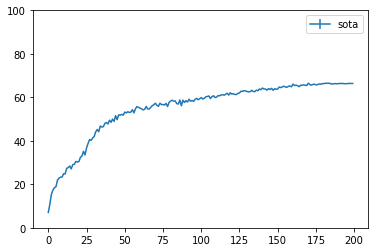

In [ ]:
plot_results([avg_accs_sota_results], ['sota'], [std_accs_sota_results], 0)